# Multi-Class Cancer Classification using Convolution Neural Networks

**Author** - Vijay Prasad

#### **Problem Statement**: 
To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Approach

1.   Segregate the Data Set to Train and Test and create their respective directories.
2.   Data Visualization of sample training data for each class.
3.   Define network and run the initial model.
4.   Add Dropouts if overfit.
5.   Check for Class Imbalance and perform Data Augmentation, if needed.
6.   Obseravation of Model Metrics





### Importing required libraries

In [ ]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive



1.   This assignment uses a dataset of about `2357` images of skin cancer types. 
2.   The dataset contains 9 sub-directories in each train and test subdirectories. 
3.   The 9 sub-directories contains the images of 9 skin cancer types 
respectively.

### Create Image Dataset

In [ ]:
# Defining the path for train and test images
data_dir_train = pathlib.Path('/content/drive/MyDrive/Colab/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/')
data_dir_test = pathlib.Path('/content/drive/MyDrive/Colab/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Test/')

In [ ]:
#Extracting the count of train and test images
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

In [ ]:
# Defining Image Size and Batch Size
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [ ]:
# Create Image Train Dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed = 123,
    validation_split = 0.2,
    subset = 'training',
    image_size = (img_height,img_width),
    shuffle=True,
    batch_size = batch_size
)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [ ]:
# Create Image Test Dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed = 123,
    validation_split = 0.2,
    subset = 'validation',
    image_size = (img_height,img_width),
    shuffle=True,
    batch_size = batch_size
)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [ ]:
# List out all the classes of skin cancer and store them in a list. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualizing data

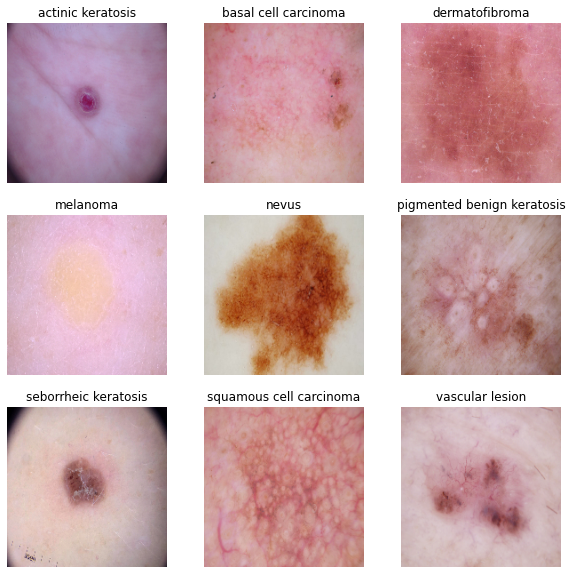

In [ ]:
# Code to visualize instance of each skin cancer type
import matplotlib.pyplot as plt

plt.figure(figsize = (10,10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[i])
        plt.axis("off")


*   The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`.
*   This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB).
*    The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.



*   `Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.
*   `Dataset.prefetch()` overlaps data preprocessing and model execution while training.



In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Model Creation

#### Model 1

In [ ]:
num_classes = 9

# Defining Network Architecture
model = Sequential([layers.experimental.preprocessing.Rescaling(1/.255, input_shape = (img_height, img_width, 3))])
model.add(Conv2D(32, (3, 3), padding='same',input_shape=(180, 180, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

#####Note:
This Network Architecture of Model 1 is constructed and choosed after testing different networks for several times

In [ ]:
## Compile the model, choose 'adam' as appropriate optimiser and 'SparseCategoricalCrossentropy' as loss function
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [ ]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 32)      896       
                                                                 
 activation (Activation)     (None, 180, 180, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 64)        18496     
                                                                 
 activation_1 (Activation)   (None, 90, 90, 64)        0         
                                                        

### Train the model

In [ ]:
epochs = 20 # Number of epochs
# Training the model
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 257s 1s/step - loss: 40.8069 - accuracy: 0.2121 - val_loss: 2.1495 - val_accuracy: 0.2483
Epoch 2/20
56/56 [==============================] - 2s 41ms/step - loss: 2.0000 - accuracy: 0.2628 - val_loss: 1.9348 - val_accuracy: 0.2595
Epoch 3/20
56/56 [==============================] - 2s 40ms/step - loss: 1.8983 - accuracy: 0.3259 - val_loss: 1.7909 - val_accuracy: 0.3848
Epoch 4/20
56/56 [==============================] - 2s 40ms/step - loss: 1.7693 - accuracy: 0.3465 - val_loss: 1.7639 - val_accuracy: 0.3445
Epoch 5/20
56/56 [==============================] - 2s 40ms/step - loss: 1.6492 - accuracy: 0.4057 - val_loss: 1.7604 - val_accuracy: 0.3826
Epoch 6/20
56/56 [==============================] - 2s 40ms/step - loss: 1.6136 - accuracy: 0.4129 - val_loss: 1.7869 - val_accuracy: 0.3870
Epoch 7/20
56/56 [==============================] - 2s 40ms/step - loss: 1.5584 - accuracy: 0.4386 - val_loss: 1.8827 - val_accuracy: 0.3691
Epoch 8/20
5

### Visualizing training results

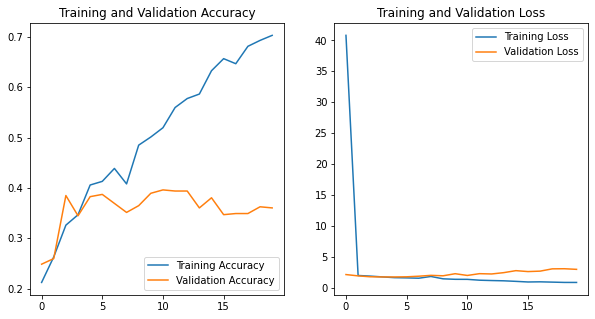

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

##### **Observation**

*   The obtained plot of Training and Validation depicts `overfitting`.
*   Loss function for training has decreased rapidly after first epoch. Both the training and validation loss function seem to be consistent between 1 to 2.
*   The training accuracy is higher than validation accuracy with a difference of approximately 0.3 which is a clear sign of overfit.
*   Lets try to overcome overfitting by adding `dropouts` in between layers.







## Model 2


In [ ]:
## Define Network Architecture by adding dropouts between layers
model2 = Sequential([layers.experimental.preprocessing.Rescaling(1/.255, input_shape = (img_height, img_width, 3))])
model2.add(Conv2D(32, (3, 3), padding='same',input_shape=(180, 180, 3)))
model2.add(Activation('relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))

model2.add(Conv2D(64, (3, 3), padding='same'))
model2.add(Activation('relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))

model2.add(Conv2D(128, (3, 3), padding='same'))
model2.add(Activation('relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))

model2.add(Flatten())
model2.add(Dense(128))
model2.add(Activation('relu'))
model2.add(BatchNormalization())
model2.add(Dropout(0.4))
model2.add(Dense(128))
model2.add(Activation('relu'))
model2.add(BatchNormalization())
model2.add(Dense(num_classes))
model2.add(Activation('softmax'))

In [ ]:
## Compiling the model
model2.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [ ]:
#view the summary of all layers
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 32)      896       
                                                                 
 activation_6 (Activation)   (None, 180, 180, 32)      0         
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 90, 90, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 64)        18496     
                                                                 
 activation_7 (Activation)   (None, 90, 90, 64)        0         
                                                      

In [ ]:
## Training code
history2 = model2.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 4s 45ms/step - loss: 2.2925 - accuracy: 0.2327 - val_loss: 4.2651 - val_accuracy: 0.2506
Epoch 2/20
56/56 [==============================] - 2s 42ms/step - loss: 1.8122 - accuracy: 0.3839 - val_loss: 3.3796 - val_accuracy: 0.1588
Epoch 3/20
56/56 [==============================] - 3s 46ms/step - loss: 1.6565 - accuracy: 0.4247 - val_loss: 6.0257 - val_accuracy: 0.2081
Epoch 4/20
56/56 [==============================] - 3s 51ms/step - loss: 1.5648 - accuracy: 0.4621 - val_loss: 4.1445 - val_accuracy: 0.3154
Epoch 5/20
56/56 [==============================] - 2s 42ms/step - loss: 1.5192 - accuracy: 0.4475 - val_loss: 3.5091 - val_accuracy: 0.3356
Epoch 6/20
56/56 [==============================] - 2s 41ms/step - loss: 1.5065 - accuracy: 0.4676 - val_loss: 3.8896 - val_accuracy: 0.2081
Epoch 7/20
56/56 [==============================] - 2s 41ms/step - loss: 1.4742 - accuracy: 0.4688 - val_loss: 3.4222 - val_accuracy: 0.3557
Epoch 8/20
56

### Visualizing the results

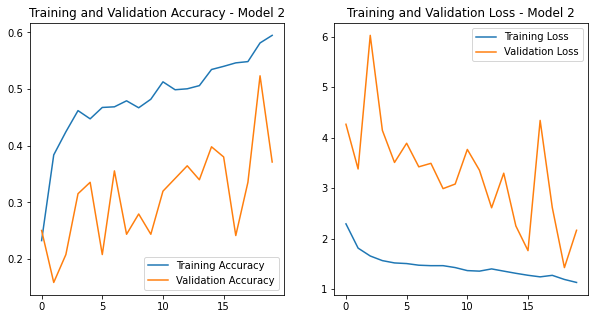

In [ ]:
# visualising training results
acc = history2.history['accuracy']
val_acc = history2.history['val_accuracy']

loss = history2.history['loss']
val_loss = history2.history['val_loss']

epochs_range = range(20)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy - Model 2')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss - Model 2')
plt.show()

##### Observation

*   The obtained plot of Training and Validation depicts `overfitting`.
*   Both the training and validation loss function decreased.
*   The training accuracy is higher than validation accuracy with a difference of approximately 0.15. But, the difference is less when compared to that of model 1. The model overfits here as well.
*   Lets try to overcome overfitting by understanding the distribution of data and balancing using `augmentor` if needed.

#### Distribution of Classes in the Training Dataset.
#### **Context:** 

*   Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. 

*   Class imbalance can have a detrimental effect on the final model quality. 
*   Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [ ]:
## Count the images of each class in their sub-directories

import glob

class_count=[]
for class_item in class_names:
    class_count.append(len(list(data_dir_train.glob(class_item + '/*.jpg'))))

df_image_class_count= pd.DataFrame(list(zip(class_names, class_count)), columns =['ClassName', 'ImageCount'])
df_image_class_count

,ClassName,ImageCount
0,actinic keratosis,114
1,basal cell carcinoma,376
2,dermatofibroma,95
3,melanoma,438
4,nevus,357
5,pigmented benign keratosis,462
6,seborrheic keratosis,77
7,squamous cell carcinoma,181
8,vascular lesion,139


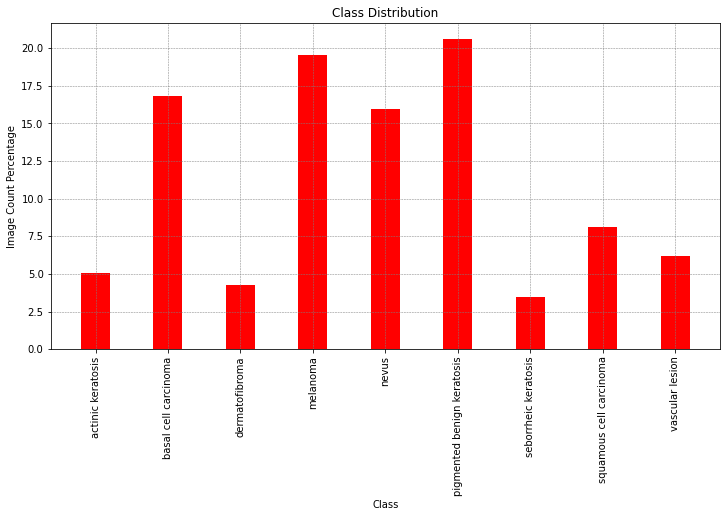

In [ ]:
fig = plt.figure(figsize = (12, 6))
 
# creating the bar plot of Training Data for each class
plt.bar(class_names, class_count/np.sum(class_count)*100, color ='red',
        width = 0.4)

plt.grid(True, color = "grey", linewidth = "0.5", linestyle = "--") 
plt.xlabel("Class")
plt.ylabel("Image Count Percentage")
plt.title("Class Distribution")
plt.xticks(rotation=90)
plt.show()

#### Observations


*   The plot above confirms the presence of `Class Imbalance`.
*   The class `'dermatofibroma'` and `'seborrheic keratosis'` have the least number of samples (less than 5% of the total each).

*   The class `'melanoma'` and `'pigmented benign keratosis'` dominate the others with the sample size (more than 18% of the total each).

*   To overcome the Class Imbalance, we will use `'Augmentor'` library.










#### Rectify Class Imbalance using Augmentor library

#### **Context:** 
You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [ ]:
#Augmentor Package installation if not installed
!pip install Augmentor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [ ]:
# path for Training Dataset
path_to_training_dataset="/content/drive/MyDrive/Colab/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"

# Importing library
import Augmentor

# Augment each class with total 500 images
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.8, max_left_rotation=20, max_right_rotation=20)
    p.flip_top_bottom(probability=0.7)
    p.flip_left_right(probability=0.7)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/drive/MyDrive/Colab/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F78A24A16D0>: 100%|██████████| 500/500 [00:23<00:00, 21.35 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/drive/MyDrive/Colab/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F79AA24F7D0>: 100%|██████████| 500/500 [00:25<00:00, 19.41 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/drive/MyDrive/Colab/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F78A24A1210>: 100%|██████████| 500/500 [00:22<00:00, 21.75 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/drive/MyDrive/Colab/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F78A2116290>: 100%|██████████| 500/500 [01:52<00:00,  4.45 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/drive/MyDrive/Colab/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=919x802 at 0x7F78A21CA3D0>: 100%|██████████| 500/500 [01:42<00:00,  4.89 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/drive/MyDrive/Colab/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F78A225FF10>: 100%|██████████| 500/500 [00:20<00:00, 23.91 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/drive/MyDrive/Colab/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F79C24DC810>: 100%|██████████| 500/500 [00:51<00:00,  9.77 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/drive/MyDrive/Colab/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F78A21D52D0>: 100%|██████████| 500/500 [00:21<00:00, 23.37 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/drive/MyDrive/Colab/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F78A21848D0>: 100%|██████████| 500/500 [00:21<00:00, 23.54 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [ ]:
# Count of the total Image set before & after Augmentation

image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print("Count of Image Train set before augmentation =",image_count_train)

image_count_train_aug = len(list(data_dir_train.glob('*/output/*.jpg')))
print("Count of Image Train set after augmentation =",image_count_train_aug)

Count of Image Train set before augmentation = 2239
Count of Image Train set after augmentation = 4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [ ]:
import glob
# Count the images of each class in their sub-directories
aug_class_count=[]
aug_folders=[]
for class_item in class_names:
    aug_folders.append(list(data_dir_train.glob(class_item + '/output/'))) 
    aug_class_count.append(len(list(data_dir_train.glob(class_item + '/output/*.jpg'))))

# Total Images after Augmentation
aug_class_item_count = np.array(aug_class_count) + np.array(class_count)

In [ ]:
# display the counts of each class using Data Frame.
dfaug_image_class_count= pd.DataFrame(list(zip(class_names, aug_class_item_count)), columns =['ClassName', 'ImageCount_Augm'])
dfaug_image_class_count

,ClassName,ImageCount_Augm
0,actinic keratosis,614
1,basal cell carcinoma,876
2,dermatofibroma,595
3,melanoma,938
4,nevus,857
5,pigmented benign keratosis,962
6,seborrheic keratosis,577
7,squamous cell carcinoma,681
8,vascular lesion,639


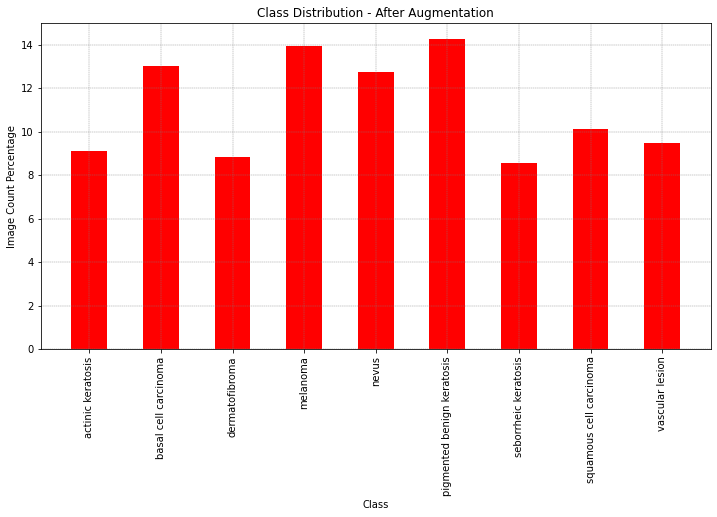

In [ ]:
fig = plt.figure(figsize = (12, 6))
 
# creating the bar plot of training data of each class after augmentation
plt.bar(class_names, aug_class_item_count/np.sum(aug_class_item_count)*100, color ='red',
        width = 0.5)

plt.grid(True, color = "grey", linewidth = "0.4", linestyle = "--") 
plt.xlabel("Class")
plt.ylabel("Image Count Percentage")
plt.title("Class Distribution - After Augmentation")
plt.xticks(rotation=90)
plt.show()

#### Observation


*   The Bar plot shows the class imbalance has been overcome.
*   Minor sized classes in the previous distribution plot such as `'dermatofibroma'` and `'seborrheic keratosis'` now contains more than 8% of the total train data set each. 
*   Major sized classes in the previous distribution plot such as `'melanoma'` and `'pigmented benign keratosis'` now reduced to 14% of the total train data set each. 





So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### Model 3 using Augmented Data



In [ ]:
batch_size = 32
img_height = 180
img_width = 180

In [ ]:
# Create the image training set for augmented data
data_dir_train="/content/drive/MyDrive/Colab/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"

aug_train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  shuffle=True,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### **Todo:** Create a validation dataset

In [ ]:
# Create the image validation set for augmented data

aug_val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  shuffle=True,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


In [ ]:
# Prefetching
AUTOTUNE = tf.data.experimental.AUTOTUNE
aug_train_ds = aug_train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
aug_val_ds = aug_val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
## Define network architecture
model3 = Sequential([layers.experimental.preprocessing.Rescaling(1/.255, input_shape = (img_height, img_width, 3))])
model3.add(Conv2D(32, (3, 3), padding='same',input_shape=(180, 180, 3)))
model3.add(Activation('relu'))
model3.add(MaxPooling2D(pool_size=(2, 2)))

model3.add(Conv2D(64, (3, 3), padding='same'))
model3.add(Activation('relu'))
model3.add(MaxPooling2D(pool_size=(2, 2)))

model3.add(Conv2D(128, (3, 3), padding='same'))
model3.add(Activation('relu'))
model3.add(MaxPooling2D(pool_size=(2, 2)))

model3.add(Dropout(0.3))
model3.add(Flatten())
model3.add(Dense(128))
model3.add(Activation('relu'))
model3.add(BatchNormalization())
model3.add(Dropout(0.4))
model3.add(Dense(128))
model3.add(Activation('relu'))
model3.add(BatchNormalization())
model3.add(Dense(num_classes))
model3.add(Activation('softmax'))


In [ ]:
## Compile the model
model3.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [ ]:
## training
epochs = 20
history3 = model3.fit(
  aug_train_ds,
  validation_data=aug_val_ds,
  epochs=epochs
)

Epoch 1/20
169/169 [==============================] - 46s 79ms/step - loss: 1.9076 - accuracy: 0.3058 - val_loss: 14.2871 - val_accuracy: 0.1099
Epoch 2/20
169/169 [==============================] - 7s 42ms/step - loss: 1.5818 - accuracy: 0.4026 - val_loss: 1.6374 - val_accuracy: 0.3846
Epoch 3/20
169/169 [==============================] - 7s 42ms/step - loss: 1.4756 - accuracy: 0.4405 - val_loss: 1.4782 - val_accuracy: 0.4633
Epoch 4/20
169/169 [==============================] - 7s 42ms/step - loss: 1.4209 - accuracy: 0.4612 - val_loss: 1.7325 - val_accuracy: 0.3935
Epoch 5/20
169/169 [==============================] - 7s 42ms/step - loss: 1.3633 - accuracy: 0.4824 - val_loss: 2.1937 - val_accuracy: 0.3333
Epoch 6/20
169/169 [==============================] - 8s 47ms/step - loss: 1.3176 - accuracy: 0.5019 - val_loss: 1.5343 - val_accuracy: 0.4536
Epoch 7/20
169/169 [==============================] - 7s 42ms/step - loss: 1.2732 - accuracy: 0.5236 - val_loss: 1.8933 - val_accuracy: 0.36

#### Visualize the Model Results

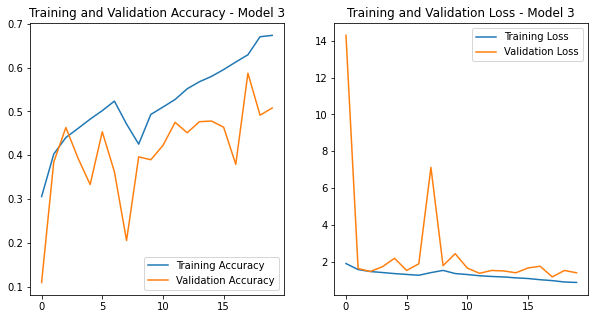

In [ ]:
acc = history3.history['accuracy']
val_acc = history3.history['val_accuracy']

loss = history3.history['loss']
val_loss = history3.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy - Model 3')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss - Model 3')
plt.show()

### **Observations**


*   The optimiser chosen is `'adam'` for all models.
*   The loss function choosen is `'SparseCategoricalCrossentropy'` for all models.
*   Model 1 is overfitted with much difference of 0.3 between Training and Validation accuracy.
*   Model 2 also overfits but with much reduce in the difference between Training and Validation accuracy which is aproximately 0.15.  
*   As the data has `Class Imbalance`, `Augmentor` is used and then proceed to investigate further.
*   Model 3 improves the training accuracy and is higher than that of previous Model 2.
*   As the metrics of the model improves at each stage, the issue of overfit is not eliminated completely. 
*  This shows the further need to use large sophesticated `CNN Architectures` of CNN such as `VGGNet, AlexNet, GoogleNet, ResNet` etc. for high accuracy, no overfit and precise predictions using `Transfer Learning`.






